# Import libs

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import lightgbm
import optuna

# Load data

In [175]:
raw_train = pd.read_csv('train.csv')
raw_train.head()

,id,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,...,Cat_175,Cat_176,Cat_177,Cat_178,Cat_179,Cat_180,Cat_181,Cat_182,Cat_183,target
0,1,4,5,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,5,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2,6,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,1,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [176]:
raw_test = pd.read_csv('test.csv')
raw_test.head()

,id,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,...,Cat_174,Cat_175,Cat_176,Cat_177,Cat_178,Cat_179,Cat_180,Cat_181,Cat_182,Cat_183
0,1,5,6,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,6,6,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,3,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,5,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# EDA

In [177]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 225 entries, id to target
dtypes: float64(7), int64(218)
memory usage: 85.8 MB


In [178]:
raw_train.select_dtypes(include='float').head()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15
0,0.9,0.4,0.957862,0.424264,1.173117,0.438292,3.605551
1,0.4,0.0,0.583095,0.446990,0.675776,0.344964,2.236068
2,0.4,0.0,0.775806,0.447214,0.706405,0.339116,2.645751
3,0.4,0.5,1.112430,0.547723,1.678110,0.532917,3.605551
4,0.6,0.2,0.716764,0.400000,0.938700,0.401746,3.741657


In [179]:
raw_train.drop(columns=['id','target']).describe()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,Cat_174,Cat_175,Cat_176,Cat_177,Cat_178,Cat_179,Cat_180,Cat_181,Cat_182,Cat_183
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.901700,4.410700,0.392260,0.256080,0.16504,0.18662,0.00038,0.002060,0.009580,0.000940,...,0.006620,0.00338,0.002500,0.005100,0.020220,0.007440,0.012660,0.003360,0.041020,0.141660
std,1.980383,2.702897,0.488259,0.436471,0.37122,0.38961,0.01949,0.045341,0.097408,0.030645,...,0.081094,0.05804,0.049938,0.071233,0.140754,0.085935,0.111803,0.057869,0.198338,0.348705
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,6.000000,1.000000,1.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,11.000000,1.000000,1.000000,1.00000,1.00000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## What is the balance of class

In [180]:
raw_train['target'].value_counts(normalize=True)

target
0    0.96356
1    0.03644
Name: proportion, dtype: float64

As we can see there is unbalanced classes

## How many features for each category

In [182]:
raw_train.columns.to_list()

['id',
 'ps_ind_01',
 'ps_ind_03',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'missing',
 'ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'new_ind_count',
 'Cat_0',
 'Cat_1',
 'Cat_2',
 'Cat_3',
 'Cat_4',
 'Cat_5',
 'Cat_6',
 'Cat_7',
 'Cat_8',
 'Cat_9',
 'Cat_10',
 'Cat_11',
 'Cat_12',
 'Cat_13',
 'Cat_14',
 'Cat_15',
 'Cat_16',
 'Cat_17',
 'Cat_18',
 'Cat_19',
 'Cat_20',
 'Cat_21',
 'Cat_22',
 'Cat_23',
 'Cat_2

In [183]:
clean_strings = [re.sub(r'\d+', '', s) for s in raw_train.columns]

unique_cols = list(set(clean_strings))

unique_cols

['ps_ind__cat_count',
 'new_ind_count',
 'Cat_',
 'missing',
 'ps_ind__bin',
 'ps_reg_',
 'id',
 'target',
 'ps_ind_',
 'ps_car__cat_count',
 'ps_car_']

In [184]:
s = 0
for col in unique_cols:
    matching_cols = list(filter(lambda column: col in str(column), raw_train.columns))
    num = len(matching_cols)
    s += num
    print(f"For '{col}' there are {num} columns")
print(f"Total {s} columns")

For 'ps_ind__cat_count' there are 0 columns
For 'new_ind_count' there are 1 columns
For 'Cat_' there are 184 columns
For 'missing' there are 1 columns
For 'ps_ind__bin' there are 0 columns
For 'ps_reg_' there are 3 columns
For 'id' there are 1 columns
For 'target' there are 1 columns
For 'ps_ind_' there are 18 columns
For 'ps_car__cat_count' there are 0 columns
For 'ps_car_' there are 16 columns
Total 225 columns


## How many nan values

In [185]:
raw_train.isna().sum().sum()

np.int64(0)

# Feature Engineering

In [336]:
fe_train = raw_train.copy()
fe_test = raw_test.copy()

## Change to category type

In [341]:
col_to_category = fe_train.columns.to_list()[:39] # until Cat_*

for col in col_to_category:
    if fe_train[col].dtype == 'int' and fe_train[col].nunique() < 10 and fe_train[col].nunique() > 2:
        fe_train[col] = fe_train[col].astype('category')
        fe_test[col] = fe_test[col].astype('category')

## Sum of Cat features with 1

In [342]:
cat_cols = [col for col in fe_train.columns if 'Cat_' in col]
fe_train['num_cat_true'] = fe_train[cat_cols].sum(axis=1)
fe_test['num_cat_true'] = fe_test[cat_cols].sum(axis=1)

## Sum of Bin features with 1

In [343]:
bin_cols = [col for col in fe_train.columns if 'bin' in col]
fe_train['sum_bin'] = fe_train[bin_cols].sum(axis=1)
fe_test['sum_bin'] = fe_test[bin_cols].sum(axis=1)

# Model train

In [344]:
X = fe_train.drop(columns=['target'])
y = fe_train['target']

## Baseline

make all samples with target 1

In [ ]:
base = pd.DataFrame(data={'id':raw_test['id'], 'target': np.repeat(1, raw_test.shape[0])})
base.to_csv("baseline_exam.csv", index=False)

## LightGBM

In [317]:
np.sqrt(X.shape[1])

np.float64(15.0)

In [ ]:
def objective_lgbm(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'max_depth': trial.suggest_int("max_depth", 8, 17),
        'num_leaves': trial.suggest_int('num_leaves', 15, 75),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'force_col_wise': True,
        'objective': 'binary',
        'n_jobs': -1,
        'random_state': 23
    }
    
    model = lightgbm.LGBMClassifier(**params)
    
    splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

    aucs = []

    for _, (train_index, valid_index) in enumerate(splitter.split(X, y)):

        X_train , y_train = X.iloc[train_index], y.iloc[train_index]
        X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]


        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  eval_metric='auc',
                  callbacks=[lightgbm.early_stopping(25, verbose=False),
                              lightgbm.log_evaluation(period=0, show_stdv=False)])
        
        y_pred_proba = model.predict_proba(X_valid)[:,1]
        aucs.append(roc_auc_score(y_valid, y_pred_proba))
    
    return np.mean(aucs)

In [373]:
study = optuna.create_study(study_name="lgbm_opt", direction="maximize")
study.optimize(objective_lgbm, n_trials=100, show_progress_bar=True)

[I 2025-12-20 14:13:34,490] A new study created in memory with name: lgbm_opt


  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 1458, number of negative: 38542
[LightGBM] [Info] Total Bins 2023
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274683
[LightGBM] [Info] Start training from score -3.274683
[LightGBM] [Info] Number of positive: 1458, number of negative: 38542
[LightGBM] [Info] Total Bins 2022
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274683
[LightGBM] [Info] Start training from score -3.274683
[LightGBM] [Info] Number of positive: 1458, number of negative: 38542
[LightGBM] [Info] Total Bins 2020
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274683
[LightGBM] [Info] Start training from score -3.274683
[Lig

In [374]:
print("Best value (F1):", study.best_value)
print("Best params:", study.best_trial.params)

Best value (F1): 0.6169595791915335
Best params: {'n_estimators': 2315, 'max_depth': 8, 'num_leaves': 36, 'learning_rate': 0.026082379503893353, 'subsample': 0.6150798682646407, 'colsample_bytree': 0.5489265043486458, 'reg_alpha': 9.373651844220582, 'reg_lambda': 0.09686732414333193}


## OOF

In [ ]:
oof_proba = np.zeros(len(X), dtype=float)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    model = lightgbm.LGBMClassifier(**study.best_trial.params, force_row_wise=True,
                                   n_jobs=-1, objective='binary', random_state=23)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="auc",
        callbacks=[lightgbm.early_stopping(80, verbose=False)]
    )

    oof_proba[va_idx] = model.predict_proba(X_va)[:, 1]

print("\nOOF ROC-AUC:", roc_auc_score(y, oof_proba))
print("OOF PR-AUC (Average Precision):", average_precision_score(y, oof_proba))

[LightGBM] [Info] Number of positive: 1458, number of negative: 38542
[LightGBM] [Info] Total Bins 2023
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274683
[LightGBM] [Info] Start training from score -3.274683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1458, number of negative: 38542
[LightGBM] [Info] Total Bins 2022
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274683
[LightGBM] [Info] Start training from score -3.274683
[LightGBM] [Info] Number of positive: 1458, number of negative: 38542
[LightGBM] [Info] Total Bins 2020
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> ini

## Find best treshold

In [376]:
thresholds = np.linspace(0.01, 0.99, 300)

f1s = []
for t in thresholds:
    pred = (oof_proba >= t).astype(int)
    f1s.append(f1_score(y, pred))

best_t = float(thresholds[int(np.argmax(f1s))])
best_f1 = float(np.max(f1s))

print("\nBest threshold:", best_t)
print("OOF Best F1:", best_f1)

# quick diagnostics at best threshold
oof_pred = (oof_proba >= best_t).astype(int)
print("\nConfusion matrix:\n")
confusion_matrix(y, oof_pred)


Best threshold: 0.04933110367892977
OOF Best F1: 0.1048951048951049

Confusion matrix:



array([[41599,  6579],
       [ 1357,   465]])

In [377]:
print("\nClassification report:\n", classification_report(y, oof_pred, digits=4))


Classification report:
               precision    recall  f1-score   support

           0     0.9684    0.8634    0.9129     48178
           1     0.0660    0.2552    0.1049      1822

    accuracy                         0.8413     50000
   macro avg     0.5172    0.5593    0.5089     50000
weighted avg     0.9355    0.8413    0.8835     50000



## Precision–Recall curve plot

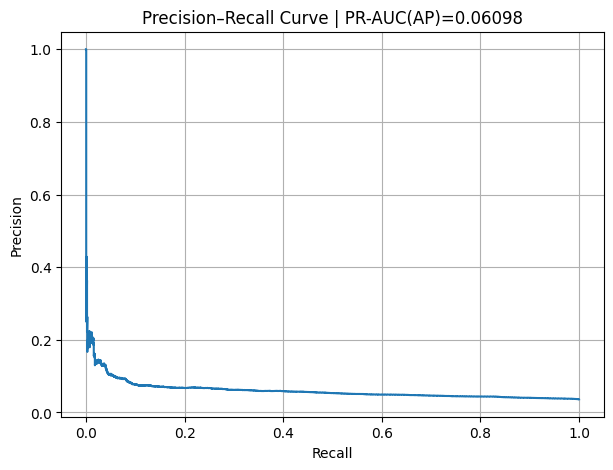

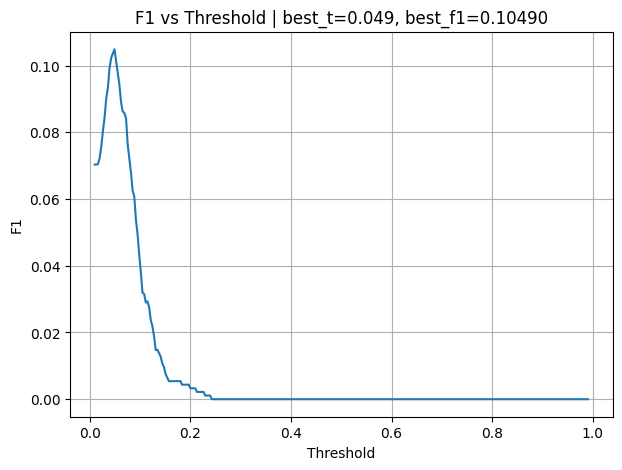

In [378]:
precision, recall, pr_thresholds = precision_recall_curve(y, oof_proba)
pr_auc = average_precision_score(y, oof_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve | PR-AUC(AP)={pr_auc:.5f}")
plt.grid()

#plot F1 vs threshold
plt.figure(figsize=(7, 5))
plt.plot(thresholds, f1s)
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title(f"F1 vs Threshold | best_t={best_t:.3f}, best_f1={best_f1:.5f}")
plt.grid()

In [379]:
thresholds = np.linspace(0.01, 0.99, 200)

f1_scores = [
    f1_score(y, (oof_proba >= t).astype(int))
    for t in thresholds
]

best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(best_t, best_f1)

0.04939698492462312 0.10525124490719782


In [ ]:
lgbm_clf = lightgbm.LGBMClassifier(**study.best_trial.params, force_row_wise=True,
                                   n_jobs=-1, objective='binary', random_state=23)

lgbm_clf.fit(X, y, callbacks=[lightgbm.log_evaluation(period=0, show_stdv=False)])

[LightGBM] [Info] Number of positive: 1822, number of negative: 48178
[LightGBM] [Info] Total Bins 2028
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036440 -> initscore=-3.274968
[LightGBM] [Info] Start training from score -3.274968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,boosting_type,'gbdt'
,num_leaves,36
,max_depth,8
,learning_rate,0.026082379503893353
,n_estimators,2315
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [381]:
preds = lgbm_clf.predict_proba(fe_test)[:, 1]
result = pd.DataFrame(data={'id':raw_test['id'], 'target':(preds >= best_t).astype(int)})
result.to_csv("submission_exam.csv", index=False)

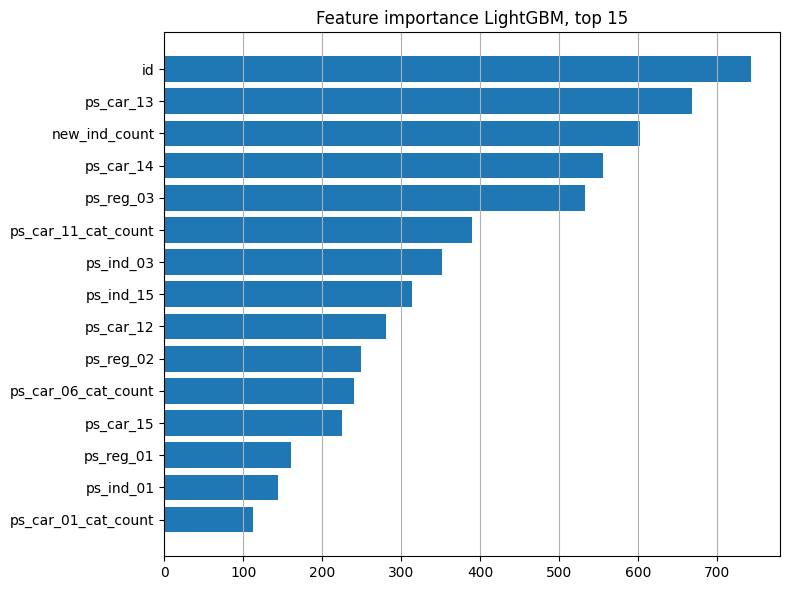

In [315]:
fi = list(zip(lgbm_clf.feature_names_in_, lgbm_clf.feature_importances_))
fi = sorted(fi, key=lambda x: x[1])

features = [x[0] for x in fi]
importances = [x[1] for x in fi]

plt.figure(figsize=(8,6))
plt.barh(features[-15:], importances[-15:])
plt.grid(axis='x')
plt.title('Feature importance LightGBM, top 15')
plt.tight_layout()

# End